Прочтём данные из файлов с результатами A/B-тестирования:

In [1]:
import pandas as pd

In [2]:
orders = pd.read_csv('datasets/orders.csv', parse_dates=['date'])

In [3]:
visitors = pd.read_csv('datasets/visitors.csv', parse_dates=['date'])

In [4]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [5]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [6]:
visitors_a = visitors.query('group == "A"').groupby(['date'], as_index=False).agg({'date' : 'max',
                                                                     'group' : 'max',
                                                                     'visitors' : 'sum'}, axis=1)
visitors_a['visitors'] = visitors_a['visitors'].cumsum()

In [7]:
visitors_a

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,1338
2,2019-08-03,A,1845
3,2019-08-04,A,2562
4,2019-08-05,A,3318
5,2019-08-06,A,3985
6,2019-08-07,A,4629
7,2019-08-08,A,5239
8,2019-08-09,A,5856
9,2019-08-10,A,6262


In [8]:
orders_aggregated = orders.groupby(['date','group'], as_index=False).agg({'date' : 'max',
                                                                          'group' : 'max',
                                                                          'transactionId' : 'nunique',
                                                                          'visitorId' : 'nunique',
                                                                          'revenue' : 'sum'}, axis=1)

In [9]:
visitors_a

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,1338
2,2019-08-03,A,1845
3,2019-08-04,A,2562
4,2019-08-05,A,3318
5,2019-08-06,A,3985
6,2019-08-07,A,4629
7,2019-08-08,A,5239
8,2019-08-09,A,5856
9,2019-08-10,A,6262


In [10]:
visitors_a_aggregated = visitors.query('group == "A"').groupby(['date'], as_index=False).agg({'date' : 'max',
                                                                                             'group' : 'max',
                                                                                             'visitors' : 'sum'}, axis=1)

In [11]:
def cumulate_column(df, column):
    grouped_by_a = df[df['group'] == 'A'][column].cumsum()
    grouped_by_b = df[df['group'] == 'B'][column].cumsum()
    cumulated = pd.concat([grouped_by_a, grouped_by_b]).reset_index()
    cumulated.sort_values(by='index', inplace=True)
    return cumulated.set_index('index')

In [12]:
visitors_aggregated = visitors.groupby(['date','group'], as_index=False).agg({'date' : 'max',
                                                                              'group' : 'max',
                                                                              'visitors' : 'sum'}, axis=1)

In [13]:
orders_aggregated = orders.groupby(['date','group'], as_index=False).agg({'date' : 'max',
                                                                          'group' : 'max',
                                                                          'transactionId' : 'nunique',
                                                                          'visitorId' : 'nunique',
                                                                          'revenue' : 'sum'}, axis=1)

In [14]:
visitors_aggregated

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,619
3,2019-08-02,B,581
4,2019-08-03,A,507
...,...,...,...
57,2019-08-29,B,531
58,2019-08-30,A,490
59,2019-08-30,B,490
60,2019-08-31,A,699


In [15]:
orders_aggregated

,date,group,transactionId,visitorId,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,20,19,93822
3,2019-08-02,B,24,23,165531
4,2019-08-03,A,24,24,112473
...,...,...,...,...,...
57,2019-08-29,B,20,20,231130
58,2019-08-30,A,11,10,86460
59,2019-08-30,B,24,24,215233
60,2019-08-31,A,12,12,61833


In [16]:
cumulate_column(visitors_aggregated, 'visitors')

,visitors
index,
0,719
1,713
2,1338
3,1294
4,1845
...,...
57,17708
58,18037
59,18198


In [17]:
cumulate_column(orders_aggregated, 'revenue')

,revenue
index,
0,148579
1,101217
2,242401
3,266748
4,354874
...,...
57,5559398
58,4022970
59,5774631


In [18]:
visitors_aggregated['visitors'] = cumulate_column(visitors_aggregated, 'visitors')
orders_aggregated['transactionId'] = cumulate_column(orders_aggregated, 'transactionId')
orders_aggregated['visitorId'] = cumulate_column(orders_aggregated, 'visitorId')

In [19]:
visitors_aggregated

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845
...,...,...,...
57,2019-08-29,B,17708
58,2019-08-30,A,18037
59,2019-08-30,B,18198
60,2019-08-31,A,18736


In [20]:
orders_aggregated

,date,group,transactionId,visitorId,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,39,93822
3,2019-08-02,B,45,43,165531
4,2019-08-03,A,68,63,112473
...,...,...,...,...,...
57,2019-08-29,B,596,584,231130
58,2019-08-30,A,545,531,86460
59,2019-08-30,B,620,608,215233
60,2019-08-31,A,557,543,61833


In [21]:
cumulativeData = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(11)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,39,93822,1338
3,2019-08-02,B,45,43,165531,1294
4,2019-08-03,A,68,63,112473,1845
5,2019-08-03,B,61,59,114248,1803
6,2019-08-04,A,84,78,70825,2562
7,2019-08-04,B,78,75,108571,2573
8,2019-08-05,A,109,103,124218,3318
9,2019-08-05,B,101,98,92428,3280


In [22]:
cumulativeData = orders_aggregated.merge(visitors_aggregated)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,39,93822,1338
3,2019-08-02,B,45,43,165531,1294
4,2019-08-03,A,68,63,112473,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,584,231130,17708
58,2019-08-30,A,545,531,86460,18037
59,2019-08-30,B,620,608,215233,18198
60,2019-08-31,A,557,543,61833,18736


In [23]:
visitors[visitors['date'] == '2019-08-05']

,date,group,visitors
4,2019-08-05,A,756
35,2019-08-05,B,707


In [24]:
orders[orders['date'] == '2019-08-05'].count()

transactionId    48
visitorId        48
date             48
revenue          48
group            48
dtype: int64

In [25]:
temp = orders[orders['date'] == '2019-08-05']

In [26]:
temp.groupby(['date'], as_index=False).agg({'date' : 'max',
                                            'group' : 'max',
                                            'transactionId' : 'nunique',
                                            'visitorId' : 'nunique',
                                            'revenue' : 'sum'}, axis=1)

,date,group,transactionId,visitorId,revenue
0,2019-08-05,B,48,47,216646


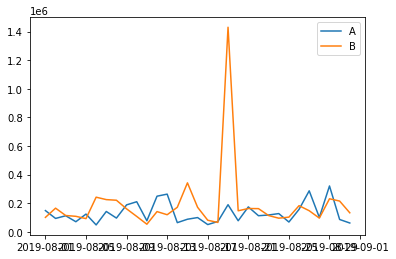

In [27]:
import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

In [28]:
from solver.ab_reporter import ABReporter

In [29]:
example = ABReporter('datasets/visitors.csv', 'datasets/orders.csv')

In [30]:
cumulated = example.grouped_summary()

In [31]:
cumulated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           62 non-null     datetime64[ns]
 1   group          62 non-null     object        
 2   orders         62 non-null     int64         
 3   buyers         62 non-null     int64         
 4   revenue        62 non-null     int64         
 5   revenue_cm     62 non-null     int64         
 6   orders_cm      62 non-null     int64         
 7   buyers_cm      62 non-null     int64         
 8   visitors       62 non-null     int64         
 9   visitors_cm    62 non-null     int64         
 10  conversion_cm  62 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 5.8+ KB


In [32]:
    cumulated_copy = cumulated.copy()
    # cumulated_copy['date'] = cumulated_copy['date'].dt.date

In [33]:
cumulated_copy['date'] = cumulated_copy['date'].dt.date

In [34]:
cumulated_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           62 non-null     object 
 1   group          62 non-null     object 
 2   orders         62 non-null     int64  
 3   buyers         62 non-null     int64  
 4   revenue        62 non-null     int64  
 5   revenue_cm     62 non-null     int64  
 6   orders_cm      62 non-null     int64  
 7   buyers_cm      62 non-null     int64  
 8   visitors       62 non-null     int64  
 9   visitors_cm    62 non-null     int64  
 10  conversion_cm  62 non-null     float64
dtypes: float64(1), int64(8), object(2)
memory usage: 5.8+ KB


In [35]:
def plot_cumulative_metrics():
    """Функция для визуализации кумулятивных метрик."""
    plt.figure(figsize=(25, 10))
    plt.style.use('seaborn-darkgrid')
    
    columns_to_pick = ['date','revenue', 'orders', 'conversion']
    cumulated_copy = cumulated.copy()
    cumulated_copy['date'] = cumulated_copy['date'].dt.date
    revenue_a = cumulated_copy.query('group == "A"')[columns_to_pick]
    revenue_b = cumulated_copy.query('group == "B"')[columns_to_pick]
    merged_revenues = revenue_a.merge(revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
    

    # кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(revenue_a['date'], revenue_a['revenue'], label='группа A')
    plt.plot(revenue_b['date'], revenue_b['revenue'], label='группа B')
    ax1.set_xticks(revenue_a['date'][::7])
    ax1.set_xticklabels(revenue_a['date'][::7])
    plt.legend()
    plt.ylabel('Выручка')
    plt.xlabel('Лайфтайм')
    plt.title('Графики кумулятивной выручки по дням и группам')
    
    ax2 = plt.subplot(2, 3, 2, sharex=ax1)    
    plt.plot(revenue_a['date'], revenue_a['revenue']/revenue_a['orders'], label='A')
    plt.plot(revenue_b['date'], revenue_b['revenue']/revenue_b['orders'], label='B')
    plt.legend()
    plt.ylabel('Средняя сумма чека')
    plt.xlabel('Лайфтайм')
    plt.title('Графики среднего чека по группам')
              
    ax3 = plt.subplot(2, 3, 3, sharex=ax1)   
    plt.plot(merged_revenues['date'], (merged_revenues['revenueB']/merged_revenues['ordersB'])/(merged_revenues['revenueA']/merged_revenues['ordersA'])-1)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.ylabel('Отношение средних чеков')
    plt.xlabel('Лайфтайм')
    plt.title('График относительного различия для среднего чека')


    ax4 = plt.subplot(2, 3, 4, sharex=ax1)
    plt.plot(revenue_a['date'], revenue_a['conversion'], label='A')
    plt.plot(revenue_b['date'], revenue_b['conversion'], label='B')
    plt.legend()
    plt.ylabel('Конверсия')
    plt.xlabel('Лайфтайм')
    plt.title('График кумулятивной конверсии')
    
    ax5 = plt.subplot(2, 3, 5, sharex=ax1)
    plt.plot(merged_revenues['date'], merged_revenues['conversionB']/merged_revenues['conversionA']-1)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=-0.1, color='grey', linestyle='--')
    plt.title('Относительный прирост конверсии группы B относительно группы A')
    plt.tight_layout()
    plt.show()

In [36]:
plot_cumulative_metrics()

KeyError: "['conversion'] not in index"

<Figure size 1800x720 with 0 Axes>

<AxesSubplot:xlabel='group,date'>

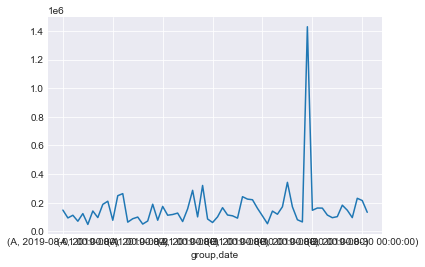

In [37]:
cumulated.groupby(['group', 'date'])['revenue'].sum().plot()

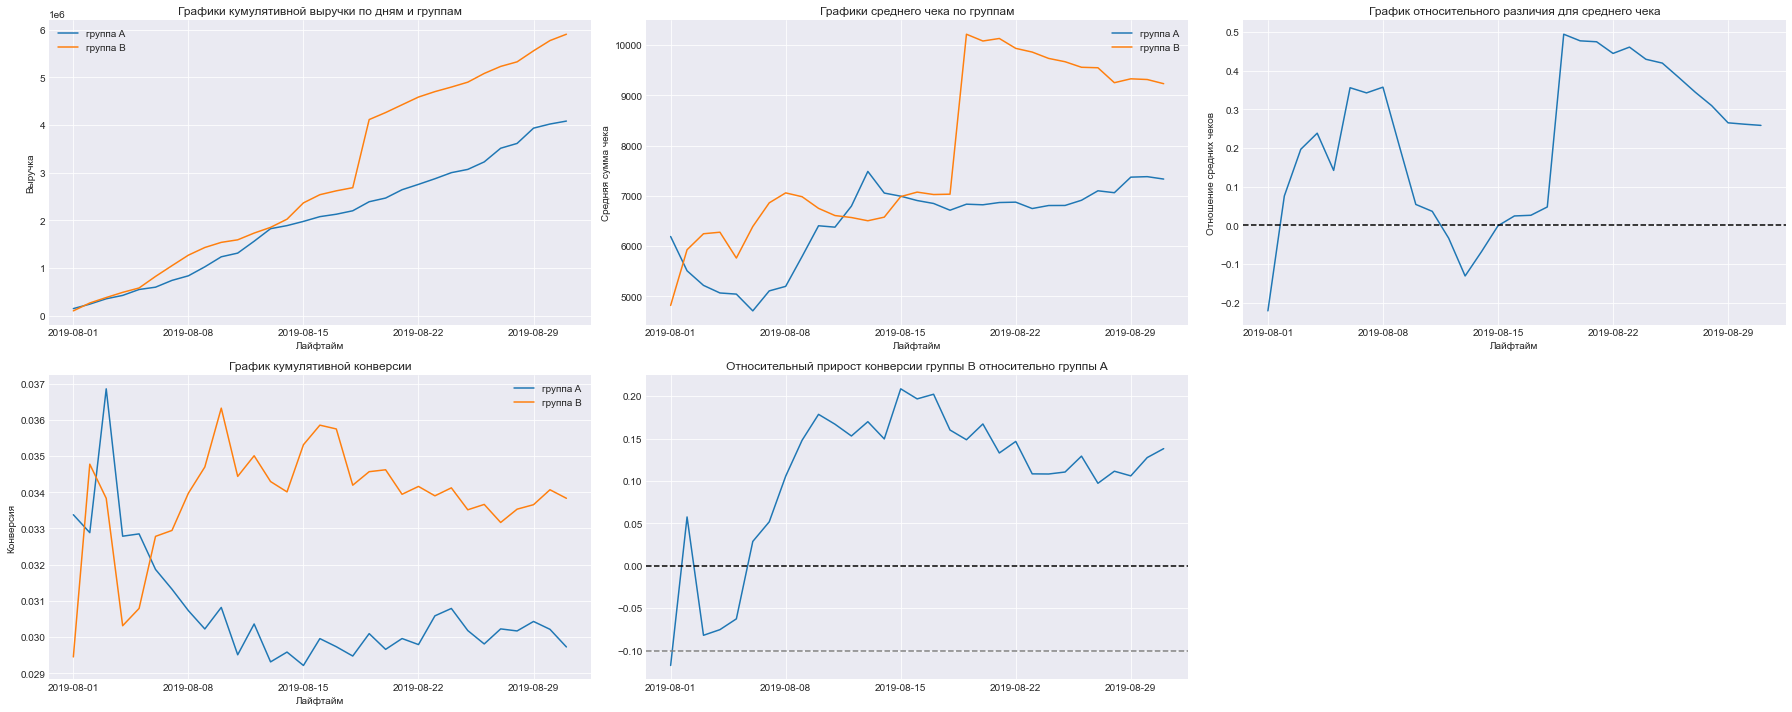

In [38]:
example.plot_cumulative_metrics()

In [39]:
columns_to_pick = ['date','revenue', 'orders']
conversion_hist = cumulated[columns_to_pick]

In [40]:
cumulated

,date,group,orders,buyers,revenue,revenue_cm,orders_cm,buyers_cm,visitors,visitors_cm,conversion_cm
0,2019-08-01,A,24,20,148579,148579,24,20,719,719,0.033380
1,2019-08-01,B,21,20,101217,101217,21,20,713,713,0.029453
2,2019-08-02,A,20,19,93822,242401,44,39,619,1338,0.032885
3,2019-08-02,B,24,23,165531,266748,45,43,581,1294,0.034776
4,2019-08-03,A,24,24,112473,354874,68,63,507,1845,0.036856
...,...,...,...,...,...,...,...,...,...,...,...
57,2019-08-29,B,20,20,231130,5559398,596,584,531,17708,0.033657
58,2019-08-30,A,11,10,86460,4022970,545,531,490,18037,0.030216
59,2019-08-30,B,24,24,215233,5774631,620,608,490,18198,0.034070
60,2019-08-31,A,12,12,61833,4084803,557,543,699,18736,0.029729


<AxesSubplot:>

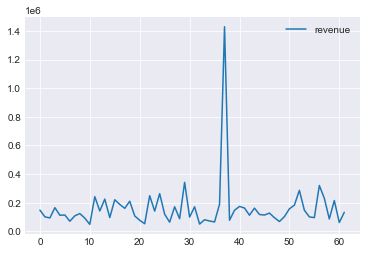

In [41]:
cumulated[['revenue']].plot()

In [42]:
columns = [name for name in conversion_hist.index.names
           if name not in ['date']]
filtered_data = conversion_hist.pivot_table(
    index='date')

In [43]:
filtered_data

,orders,revenue
date,,
2019-08-01,22.5,124898.0
2019-08-02,22.0,129676.5
2019-08-03,20.0,113360.5
2019-08-04,16.5,89698.0
2019-08-05,24.0,108323.0
2019-08-06,23.0,145413.0
2019-08-07,21.0,183875.5
2019-08-08,21.5,158598.5
2019-08-09,20.5,174659.0


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:


In [44]:
df = visitors.groupby(['date','group'], as_index=False).agg({'date' : 'max',
                                                        'group' : 'max',
                                                        'visitors' : 'sum'}, axis=1).sort_values(by=['date','group'])

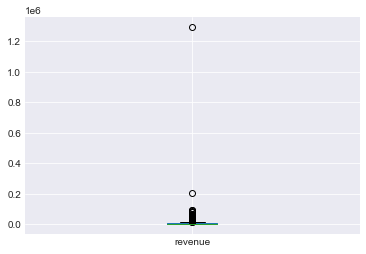

In [45]:
orders.boxplot('revenue')
plt.xlimit=2000

In [46]:
import seaborn as sns

Text(0.5, 1.0, 'Диаграмма размаха для выручки')

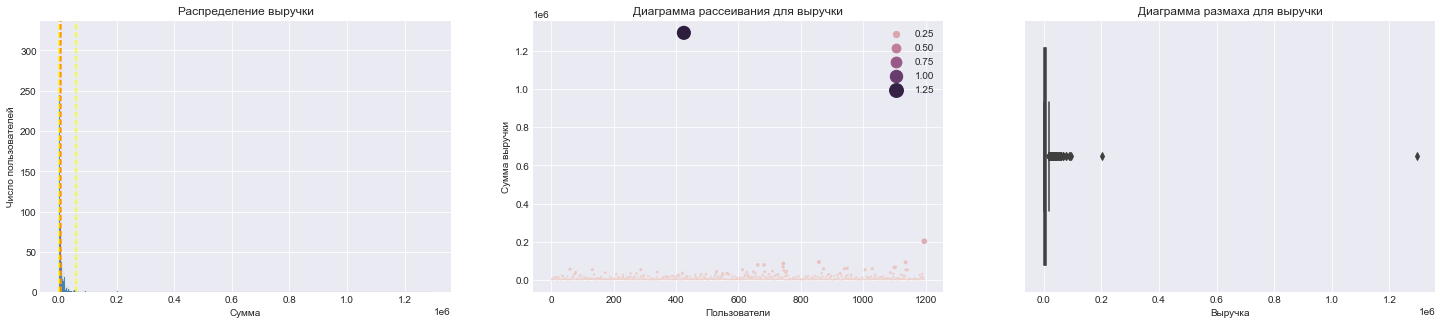

In [47]:
plt.figure(figsize=(25, 5))
x_values = pd.Series(range(0, len(orders['revenue'])))
ax1 = plt.subplot(1, 3, 1)
sns.histplot(data=orders, x='revenue')
ax1.axvline(orders['revenue'].median(),linestyle = '--', color = '#FF1493', label = 'median')
ax1.axvline(orders['revenue'].mean(),linestyle = '--', color = 'orange', label = 'mean')
ax1.axvline(orders['revenue'].quantile(0.1),linestyle = '--', color = 'yellow', label = '1%')
ax1.axvline(orders['revenue'].quantile(0.99),linestyle = '--', color = 'yellow', label = '99%')
plt.ylabel('Число пользователей')
plt.xlabel('Сумма')
plt.title('Распределение выручки')

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(ax=ax2, x=x_values, y=orders['revenue'], hue=orders['revenue'], size=orders['revenue'], sizes=(1, 200), linewidth=0, data=orders)
plt.legend()
plt.ylabel('Сумма выручки')
plt.xlabel('Пользователи')
plt.title('Диаграмма рассеивания для выручки')

ax = plt.subplot(1, 3, 3)
sns.boxplot(x=orders['revenue'])
plt.xlabel('Выручка')
plt.title('Диаграмма размаха для выручки')

In [48]:
def plotter(data, column):
    plt.figure(figsize=(25, 5))

    ax1 = plt.subplot(1, 3, 1)
    sns.histplot(data=data, x=column)
    ax1.axvline(data[column].median(),linestyle = '--', color = '#FF1493', label = 'median')
    ax1.axvline(data[column].mean(),linestyle = '--', color = 'orange', label = 'mean')
    ax1.axvline(data[column].quantile(0.1),linestyle = '--', color = 'yellow', label = '1%')
    ax1.axvline(data[column].quantile(0.99),linestyle = '--', color = 'yellow', label = '99%')
    plt.ylabel('Число пользователей')
    plt.xlabel('Сумма')
    plt.title('Распределение выручки')

    ax2 = plt.subplot(1, 3, 2)
    sns.scatterplot(ax=ax2, x=x_values, y=data[column], hue=data[column], size=data[column], sizes=(1, 200), linewidth=0, data=data)
    plt.legend()
    plt.ylabel('Сумма выручки')
    plt.xlabel('Пользователи')
    plt.title('Диаграмма рассеивания для выручки')

    ax = plt.subplot(1, 3, 3)
    sns.boxplot(x=data[column])
    plt.xlabel('Выручка')
    plt.title('Диаграмма размаха для выручки')
    plt.tight_layout()
    plt.show()

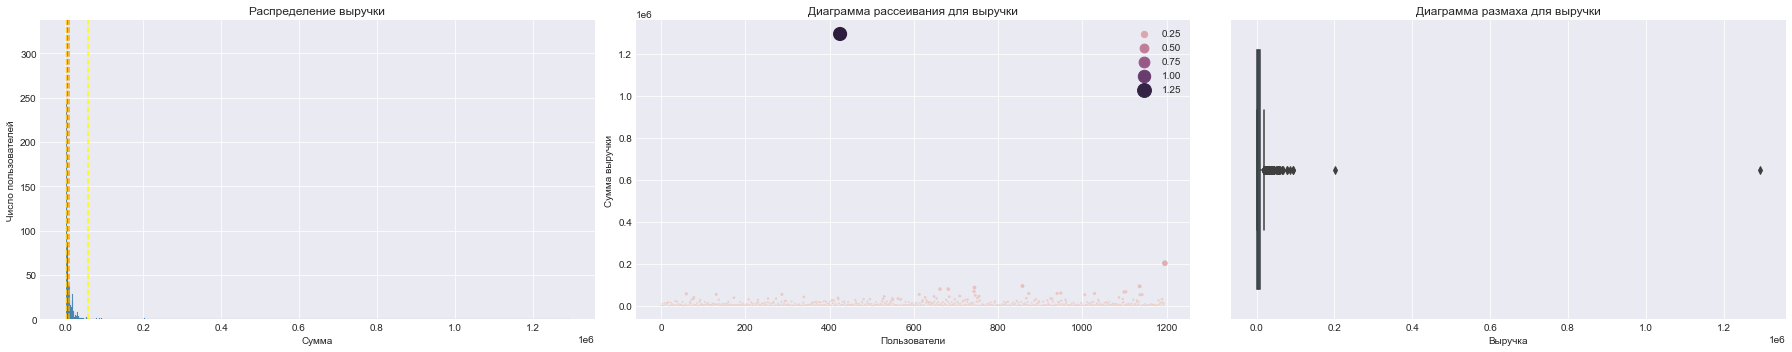

In [49]:
plotter(orders, 'revenue')

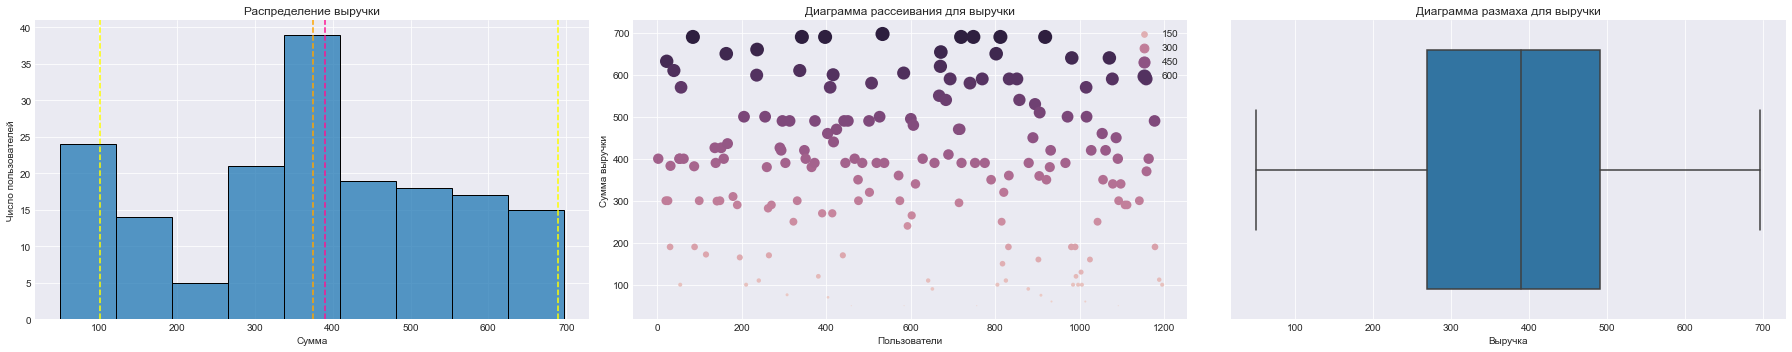

In [50]:
plotter(orders.query('revenue < 700'), 'revenue')

In [51]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [52]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


In [53]:
ordersByUsers

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


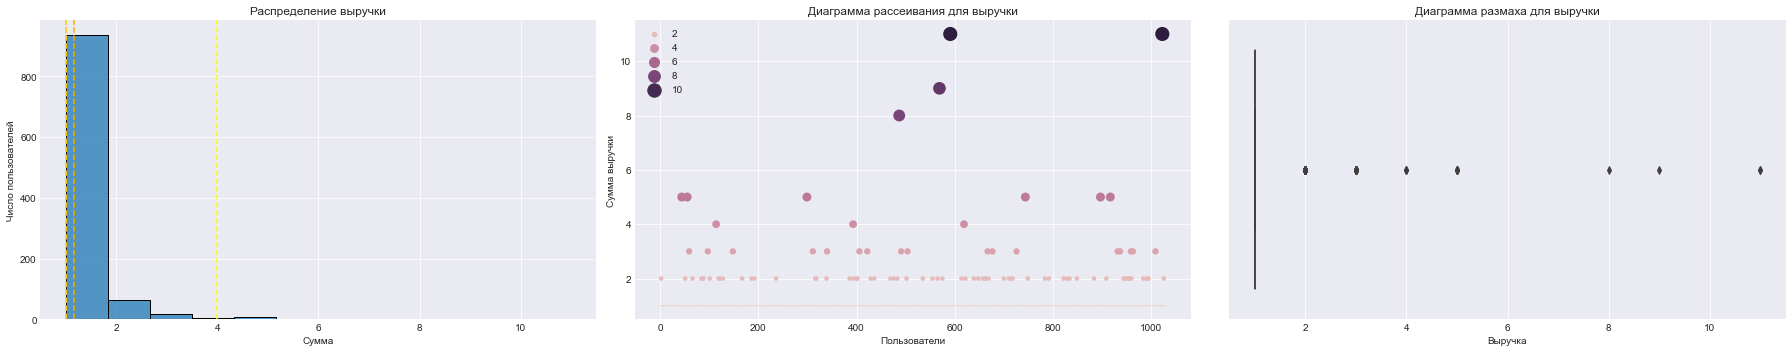

In [54]:
plotter(ordersByUsers, 'orders')

In [55]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np

visitors = pd.read_csv('datasets/visitors.csv')

orders = pd.read_csv('datasets/orders.csv')

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders'),],axis=0,)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))


         date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0  2019-08-01              24           148579              21   
1  2019-08-02              20            93822              24   
2  2019-08-03              24           112473              16   
3  2019-08-04              16            70825              17   
4  2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61           

In [58]:
sampleA

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18736, dtype: int64

In [136]:
data

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935
6,2019-08-07,18,142417,24,225334,145,740818,153,1049671,644,709,4629,4644
7,2019-08-08,16,96279,27,220918,161,837097,180,1270589,610,654,5239,5298
8,2019-08-09,16,188506,25,160812,177,1025603,205,1431401,617,610,5856,5908
9,2019-08-10,16,210495,23,107802,193,1236098,228,1539203,406,369,6262,6277


In [137]:
cumulated

,date,group,orders,buyers,revenue,revenue_cm,orders_cm,buyers_cm,visitors,visitors_cm,conversion_cm
0,2019-08-01,A,24,20,148579,148579,24,20,719,719,0.033380
1,2019-08-01,B,21,20,101217,101217,21,20,713,713,0.029453
2,2019-08-02,A,20,19,93822,242401,44,39,619,1338,0.032885
3,2019-08-02,B,24,23,165531,266748,45,43,581,1294,0.034776
4,2019-08-03,A,24,24,112473,354874,68,63,507,1845,0.036856
...,...,...,...,...,...,...,...,...,...,...,...
57,2019-08-29,B,20,20,231130,5559398,596,584,531,17708,0.033657
58,2019-08-30,A,11,10,86460,4022970,545,531,490,18037,0.030216
59,2019-08-30,B,24,24,215233,5774631,620,608,490,18198,0.034070
60,2019-08-31,A,12,12,61833,4084803,557,543,699,18736,0.029729


In [59]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [60]:
ordersByUsersA

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
498,4243832526,1
499,4256040402,7
500,4259830713,1
501,4266935830,1


In [77]:
ordersByUsersB

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1
...,...,...
581,4258103007,1
582,4266935830,1
583,4279090005,1
584,4281247801,1


In [65]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])))

0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Length: 18233, dtype: int64

In [72]:
list_of_shit = pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])))

In [80]:
pd.concat([ordersByUsersA['orders'], list_of_shit])[499]

499    7
499    0
dtype: int64

In [83]:
orders.query('group == "B"')

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1189,4082620617,393266494,2019-08-14,31550,B
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B


In [82]:
np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders']))

array([    0,     1,     2, ..., 18327, 18328, 18329], dtype=int64)

In [84]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np

In [ ]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders'),],axis=0,)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders', ),], axis=0,
)

In [135]:
orders.query('group == "A"').groupby('visitorId', as_index=False).agg({'transactionId': 'count'})

,visitorId,transactionId
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
498,4243832526,1
499,4256040402,7
500,4259830713,1
501,4266935830,1


In [104]:
def mannwhitneyu():
    columns = ['userId', 'orders']
    orders_by_a = (orders.query('group == "A"').groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
    orders_by_b = (orders.query('group == "B"').groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
    
    result = stats.mannwhitneyu(sampleA, sampleB)
    ratio = (data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1
    print(f'{result[1]:.5f}')
    print(f'{ratio:.3f}')

In [105]:
mannwhitneyu()

0.01679
0.138


In [130]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders'),],axis=0,)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders',),], axis=0,)
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))


0.01679
0.138


In [131]:
ordersByUsersA['orders']

0      1
1      1
2      1
3      1
4      1
      ..
498    1
499    7
500    1
501    1
502    1
Name: orders, Length: 503, dtype: int64

In [106]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


In [ ]:
ouliers_a = 

In [118]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],],axis=0,)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders',),],axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders',),],axis=0,)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01304
0.173


In [119]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
-0.020


In [ ]:
sampleAFiltered = ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders']
sampleBFiltered = ordersByUsersB[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders']

In [127]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01304
0.173


In [128]:
sampleAFiltered

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18690, dtype: int64

In [129]:
sampleBFiltered

0        1
1        1
2        1
3        1
4        1
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, Length: 18869, dtype: int64

In [123]:
sampleAFiltered = ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders']
sampleBFiltered = ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders']

In [124]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.74295
0.004
